In [18]:
!pip install netCDF4
!pip install numpy
!pip install matplotlib
!pip install --upgrade openpyxl
!pip install --upgrade xlrd
!pip install --upgrade pandas

DEPRECATION: Loading egg at /Users/couttsj/anaconda3/lib/python3.11/site-packages/ml_collections-0.1.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/couttsj/anaconda3/lib/python3.11/site-packages/immutabledict-3.0.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/couttsj/anaconda3/lib/python3.11/site-packages/docker-6.1.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/couttsj/anaconda3/lib/python3.11/site-packages/dm_haiku-0.0.10-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/couttsj/anaconda3/lib/pytho

# Test reading in CDF and compound list data for plotting

# Total Ion Chromatogram (TIC) Plotting

Here a single CDF file and a compound list have been used to generate the plots that are found in MANIC.

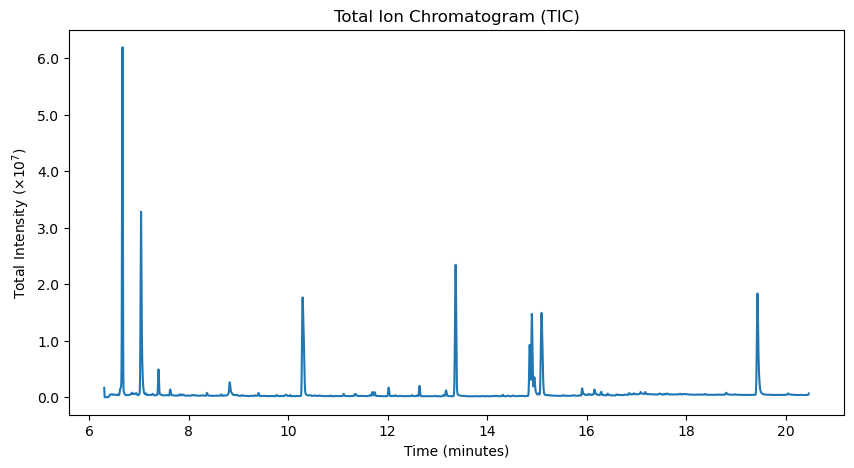

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

def read_gcms_cdf(file_path):
    cdf_file = netCDF4.Dataset(file_path, 'r')
    scan_acquisition_time = cdf_file.variables['scan_acquisition_time'][:]
    mass_values = cdf_file.variables['mass_values'][:]
    intensity_values = cdf_file.variables['intensity_values'][:]
    scan_index = cdf_file.variables['scan_index'][:]
    cdf_file.close()
    return scan_acquisition_time, mass_values, intensity_values, scan_index

def convert_to_minutes(scan_acquisition_time):
    # Assuming scan_acquisition_time is in seconds, convert it to minutes
    return scan_acquisition_time / 60.0

def compute_tic(scan_index, intensity_values):
    tic = []
    num_scans = len(scan_index)
    
    for i in range(num_scans - 1):
        start_idx = scan_index[i]
        end_idx = scan_index[i + 1]
        tic.append(np.sum(intensity_values[start_idx:end_idx]))
    
    # Handle the last scan
    start_idx = scan_index[-1]
    tic.append(np.sum(intensity_values[start_idx:]))
    
    return np.array(tic)

def scientific_format(x, pos):
    return f'{x * 1e-7:.1f}'

def plot_tic(scan_acquisition_time, tic):
    plt.figure(figsize=(10, 5), facecolor='white')  # Set the figure background to white
    ax = plt.axes()
    ax.set_facecolor('white')  # Set the axes background to white
    plt.plot(scan_acquisition_time, tic)
    plt.title('Total Ion Chromatogram (TIC)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Total Intensity')
    
    # Set the y-axis formatter to use scientific notation with exponent
    ax.yaxis.set_major_formatter(FuncFormatter(scientific_format))
    
    # Add y-axis label with the exponent
    plt.ylabel('Total Intensity ($\\times 10^{7}$)')
    
    plt.show()

# Example usage
file_path = 'AB220926_73.cdf'
scan_acquisition_time, mass_values, intensity_values, scan_index = read_gcms_cdf(file_path)

# Convert scan acquisition times to minutes
scan_acquisition_time = convert_to_minutes(scan_acquisition_time)

# Compute the TIC
tic = compute_tic(scan_index, intensity_values)

# Plot the TIC
plot_tic(scan_acquisition_time, tic)



# Extract Ion Chromatogram (EIC) Plotting

Retention time for C12:0: 10.28 minutes
Target mass (m/z) for C12:0: 272
lOffset: 0.1, rOffset: 0.1


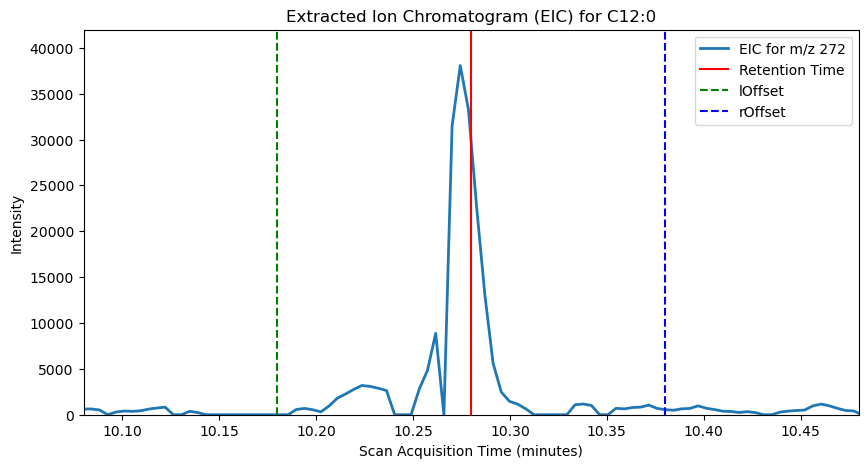

In [19]:
import pandas as pd
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file using xlrd
excel_file = 'compound_list.xls'
data = pd.read_excel(excel_file, engine='xlrd')

# Extract the relevant data for C12:0
compound_row = data[data['name'] == 'C12:0'].iloc[0]
retention_time = compound_row['tR']
target_mass = compound_row['Mass0']
l_offset = compound_row['lOffset']
r_offset = compound_row['rOffset']
print(f'Retention time for C12:0: {retention_time} minutes')
print(f'Target mass (m/z) for C12:0: {target_mass}')
print(f'lOffset: {l_offset}, rOffset: {r_offset}')

def read_gcms_cdf(file_path):
    cdf_file = netCDF4.Dataset(file_path, 'r')
    scan_acquisition_time = cdf_file.variables['scan_acquisition_time'][:]
    mass_values = cdf_file.variables['mass_values'][:]
    intensity_values = cdf_file.variables['intensity_values'][:]
    scan_index = cdf_file.variables['scan_index'][:]
    cdf_file.close()
    return scan_acquisition_time, mass_values, intensity_values, scan_index

file_path = 'AB220926_01.cdf'
scan_acquisition_time, mass_values, intensity_values, scan_index = read_gcms_cdf(file_path)

def extract_eic(scan_index, mass_values, intensity_values, scan_acquisition_time, target_mass, mass_tolerance=0.25):
    eic_time = []
    eic_intensity = []
    num_scans = len(scan_index)
    
    for i in range(num_scans - 1):
        start_idx = scan_index[i]
        end_idx = scan_index[i + 1]
        
        scan_mass_values = mass_values[start_idx:end_idx]
        scan_intensity_values = intensity_values[start_idx:end_idx]
        
        # Filter intensities for the target mass within the specified tolerance
        mask = np.abs(scan_mass_values - target_mass) <= mass_tolerance
        eic_intensity.append(np.sum(scan_intensity_values[mask]))
        eic_time.append(scan_acquisition_time[i] / 60.0)  # Convert to minutes
    
    # Handle the last scan
    start_idx = scan_index[-1]
    scan_mass_values = mass_values[start_idx:]
    scan_intensity_values = intensity_values[start_idx:]
    
    mask = np.abs(scan_mass_values - target_mass) <= mass_tolerance
    eic_intensity.append(np.sum(scan_intensity_values[mask]))
    eic_time.append(scan_acquisition_time[-1] / 60.0)  # Convert to minutes
    
    return np.array(eic_time), np.array(eic_intensity)

def plot_eic(eic_time, eic_intensity, retention_time, l_offset, r_offset, target_mass):
    plt.figure(figsize=(10, 5))
    plt.plot(eic_time, eic_intensity, label=f'EIC for m/z {target_mass}', linewidth=2)
    plt.title(f'Extracted Ion Chromatogram (EIC) for C12:0')
    plt.xlabel('Scan Acquisition Time (minutes)')
    plt.ylabel('Intensity')
    
    # Add vertical lines for lOffset, rOffset, and retention time
    plt.axvline(x=retention_time, color='r', linestyle='-', label='Retention Time')
    plt.axvline(x=retention_time - l_offset, color='g', linestyle='--', label='lOffset')
    plt.axvline(x=retention_time + r_offset, color='b', linestyle='--', label='rOffset')
    
    # Set x-axis limits to a 30-second window around the retention time
    plt.xlim(retention_time - 0.2, retention_time + 0.2)  # Adjust this if your scan times are in different units
    
    # Set y-axis to start at 0
    plt.ylim(bottom=0)
    
    plt.legend()
    plt.show()

# Extract EIC
eic_time, eic_intensity = extract_eic(scan_index, mass_values, intensity_values, scan_acquisition_time, target_mass)

# Plot EIC
plot_eic(eic_time, eic_intensity, retention_time, l_offset, r_offset, target_mass)


Retention time for C12:0: 10.28 minutes
Target mass (m/z) for C12:0: 272
lOffset: 0.1, rOffset: 0.1


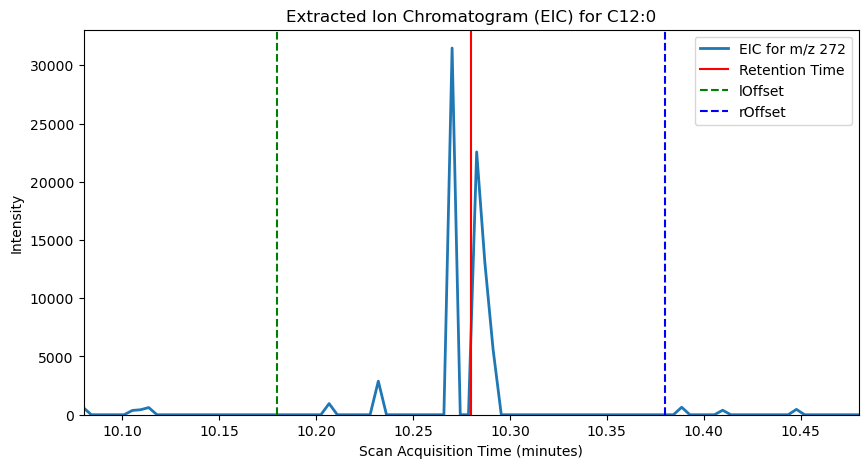

In [8]:
import pandas as pd
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file using xlrd
excel_file = 'compound_list.xls'
data = pd.read_excel(excel_file, engine='xlrd')

# Extract the relevant data for C12:0
compound_row = data[data['name'] == 'C12:0'].iloc[0]
retention_time = compound_row['tR']
target_mass = compound_row['Mass0']
l_offset = compound_row['lOffset']
r_offset = compound_row['rOffset']
print(f'Retention time for C12:0: {retention_time} minutes')
print(f'Target mass (m/z) for C12:0: {target_mass}')
print(f'lOffset: {l_offset}, rOffset: {r_offset}')

def read_gcms_cdf(file_path):
    cdf_file = netCDF4.Dataset(file_path, 'r')
    scan_acquisition_time = cdf_file.variables['scan_acquisition_time'][:]
    mass_values = cdf_file.variables['mass_values'][:]
    intensity_values = cdf_file.variables['intensity_values'][:]
    scan_index = cdf_file.variables['scan_index'][:]
    cdf_file.close()
    return scan_acquisition_time, mass_values, intensity_values, scan_index

file_path = 'AB220926_01.cdf'
scan_acquisition_time, mass_values, intensity_values, scan_index = read_gcms_cdf(file_path)

def extract_eic(scan_index, mass_values, intensity_values, scan_acquisition_time, target_mass):
    eic_time = []
    eic_intensity = []
    num_scans = len(scan_index)
    
    for i in range(num_scans - 1):
        start_idx = scan_index[i]
        end_idx = scan_index[i + 1]
        
        scan_mass_values = mass_values[start_idx:end_idx]
        scan_intensity_values = intensity_values[start_idx:end_idx]
        
        # Filter intensities for the exact target mass
        mask = scan_mass_values == target_mass
        eic_intensity.append(np.sum(scan_intensity_values[mask]))
        eic_time.append(scan_acquisition_time[i] / 60.0)  # Convert to minutes
    
    # Handle the last scan
    start_idx = scan_index[-1]
    scan_mass_values = mass_values[start_idx:]
    scan_intensity_values = intensity_values[start_idx:]
    
    mask = scan_mass_values == target_mass
    eic_intensity.append(np.sum(scan_intensity_values[mask]))
    eic_time.append(scan_acquisition_time[-1] / 60.0)  # Convert to minutes
    
    return np.array(eic_time), np.array(eic_intensity)

def plot_eic(eic_time, eic_intensity, retention_time, l_offset, r_offset, target_mass):
    plt.figure(figsize=(10, 5))
    plt.plot(eic_time, eic_intensity, label=f'EIC for m/z {target_mass}', linewidth=2)
    plt.title(f'Extracted Ion Chromatogram (EIC) for C12:0')
    plt.xlabel('Scan Acquisition Time (minutes)')
    plt.ylabel('Intensity')
    
    # Add vertical lines for lOffset, rOffset, and retention time
    plt.axvline(x=retention_time, color='r', linestyle='-', label='Retention Time')
    plt.axvline(x=retention_time - l_offset, color='g', linestyle='--', label='lOffset')
    plt.axvline(x=retention_time + r_offset, color='b', linestyle='--', label='rOffset')
    
    # Set x-axis limits to a 30-second window around the retention time
    plt.xlim(retention_time - 0.2, retention_time + 0.2)  # Adjust this if your scan times are in different units
    
    # Set y-axis to start at 0
    plt.ylim(bottom=0)
    
    plt.legend()
    plt.show()

# Extract EIC
eic_time, eic_intensity = extract_eic(scan_index, mass_values, intensity_values, scan_acquisition_time, target_mass)

# Plot EIC
plot_eic(eic_time, eic_intensity, retention_time, l_offset, r_offset, target_mass)


# Mass Spectrum Plotting

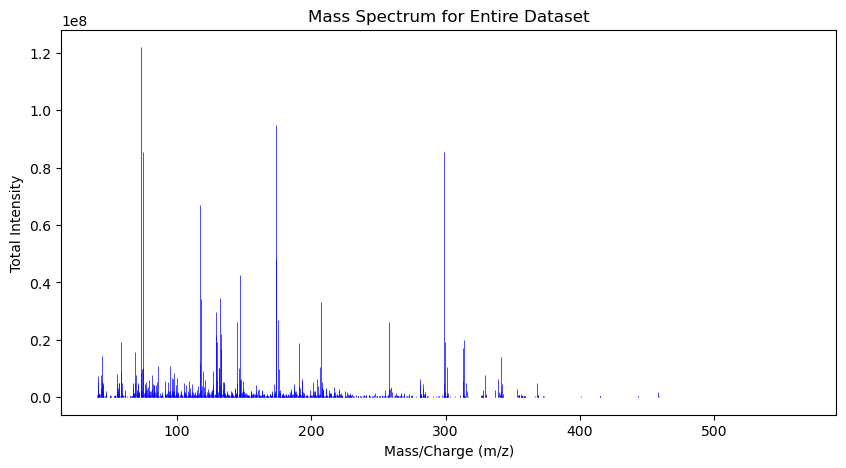

In [31]:
import pandas as pd
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

def read_gcms_cdf(file_path):
    cdf_file = netCDF4.Dataset(file_path, 'r')
    scan_acquisition_time = cdf_file.variables['scan_acquisition_time'][:]
    mass_values = cdf_file.variables['mass_values'][:]
    intensity_values = cdf_file.variables['intensity_values'][:]
    scan_index = cdf_file.variables['scan_index'][:]
    cdf_file.close()
    return scan_acquisition_time, mass_values, intensity_values, scan_index

def compute_total_mass_spectrum(mass_values, intensity_values):
    unique_masses = np.unique(mass_values)
    total_intensities = np.zeros_like(unique_masses, dtype=np.float64)

    for mass, intensity in zip(mass_values, intensity_values):
        total_intensities[unique_masses == mass] += intensity

    return unique_masses, total_intensities

def plot_mass_spectrum(mass_values, intensity_values):
    plt.figure(figsize=(10, 5))
    plt.vlines(mass_values, ymin=0, ymax=intensity_values, colors='b', linewidth=0.5)
    plt.title('Mass Spectrum for Entire Dataset')
    plt.xlabel('Mass/Charge (m/z)')
    plt.ylabel('Total Intensity')
    plt.show()

# Example usage
file_path = 'AB220926_73.cdf'
scan_acquisition_time, mass_values, intensity_values, scan_index = read_gcms_cdf(file_path)

# Compute the total mass spectrum
total_mass_values, total_intensities = compute_total_mass_spectrum(mass_values, intensity_values)

# Plot the total mass spectrum
plot_mass_spectrum(total_mass_values, total_intensities)
